In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_human_def.h5',
                               '--model-name', 'Melania_Erythroid_human_model.cpt',
                               '--exp-name', 'CohAE_Melania_Erythroid_human',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Early Erythroid", "Mid  Erythroid"), ('Mid  Erythroid', "Late Erythroid")]
k_cluster = "type2"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
        
    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
par_path = "/data/users/cqiao/notebooks/projects/PaperRev/VeloRep2/notebooks/Melania_human/"
fast_data_path = "data.h5ad"
if fast_data_path in os.listdir(par_path):
    adata = scanpy.read_h5ad(os.path.join(par_path, fast_data_path))
else:
    adata = scanpy.read_h5ad(args.data_dir)
    sel = np.zeros(adata.n_obs, dtype=np.bool)
    sel = sel | (adata.obs.celltype == "Erythroid1").values | (adata.obs.celltype == "Erythroid2").values | (adata.obs.celltype == "Erythroid3").values
    sel = sel | (adata.obs.celltype == "Blood progenitors 1").values | sel | (adata.obs.celltype == "Blood progenitors 2").values
    adata = adata[sel]
    scv.utils.show_proportions(adata)
    scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
    scv.tl.velocity_graph(adata, vkey='stc_velocity')
    scv.tl.velocity_confidence(adata, vkey='stc_velocity')

print(adata)



AnnData object with n_obs × n_vars = 35877 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'type', 'samp', 'leiden', 'type2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'stc_velocity_self_transition', 'stc_velocity_length', 'stc_velocity_confidence', 'stc_velocity_confidence_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'stc_velocity_gamma', 'stc_velocity_r2', 'stc_velocity_genes'
    uns: 'leiden', 'neighbors', 'stc_velocity_graph', 'stc_velocity_graph_neg', 'stc_velocity_params', 'type2_colors'
    obsm: 'X_pca', 'X_umap', 'stc_velocity_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'stc_velocity', 'unspliced', 'variance_stc_velocity'
    obsp: 'connectivities', 'distances'


saving figure to file ./figures/scvelo_Melania_Erythroid_human_stochastical.png


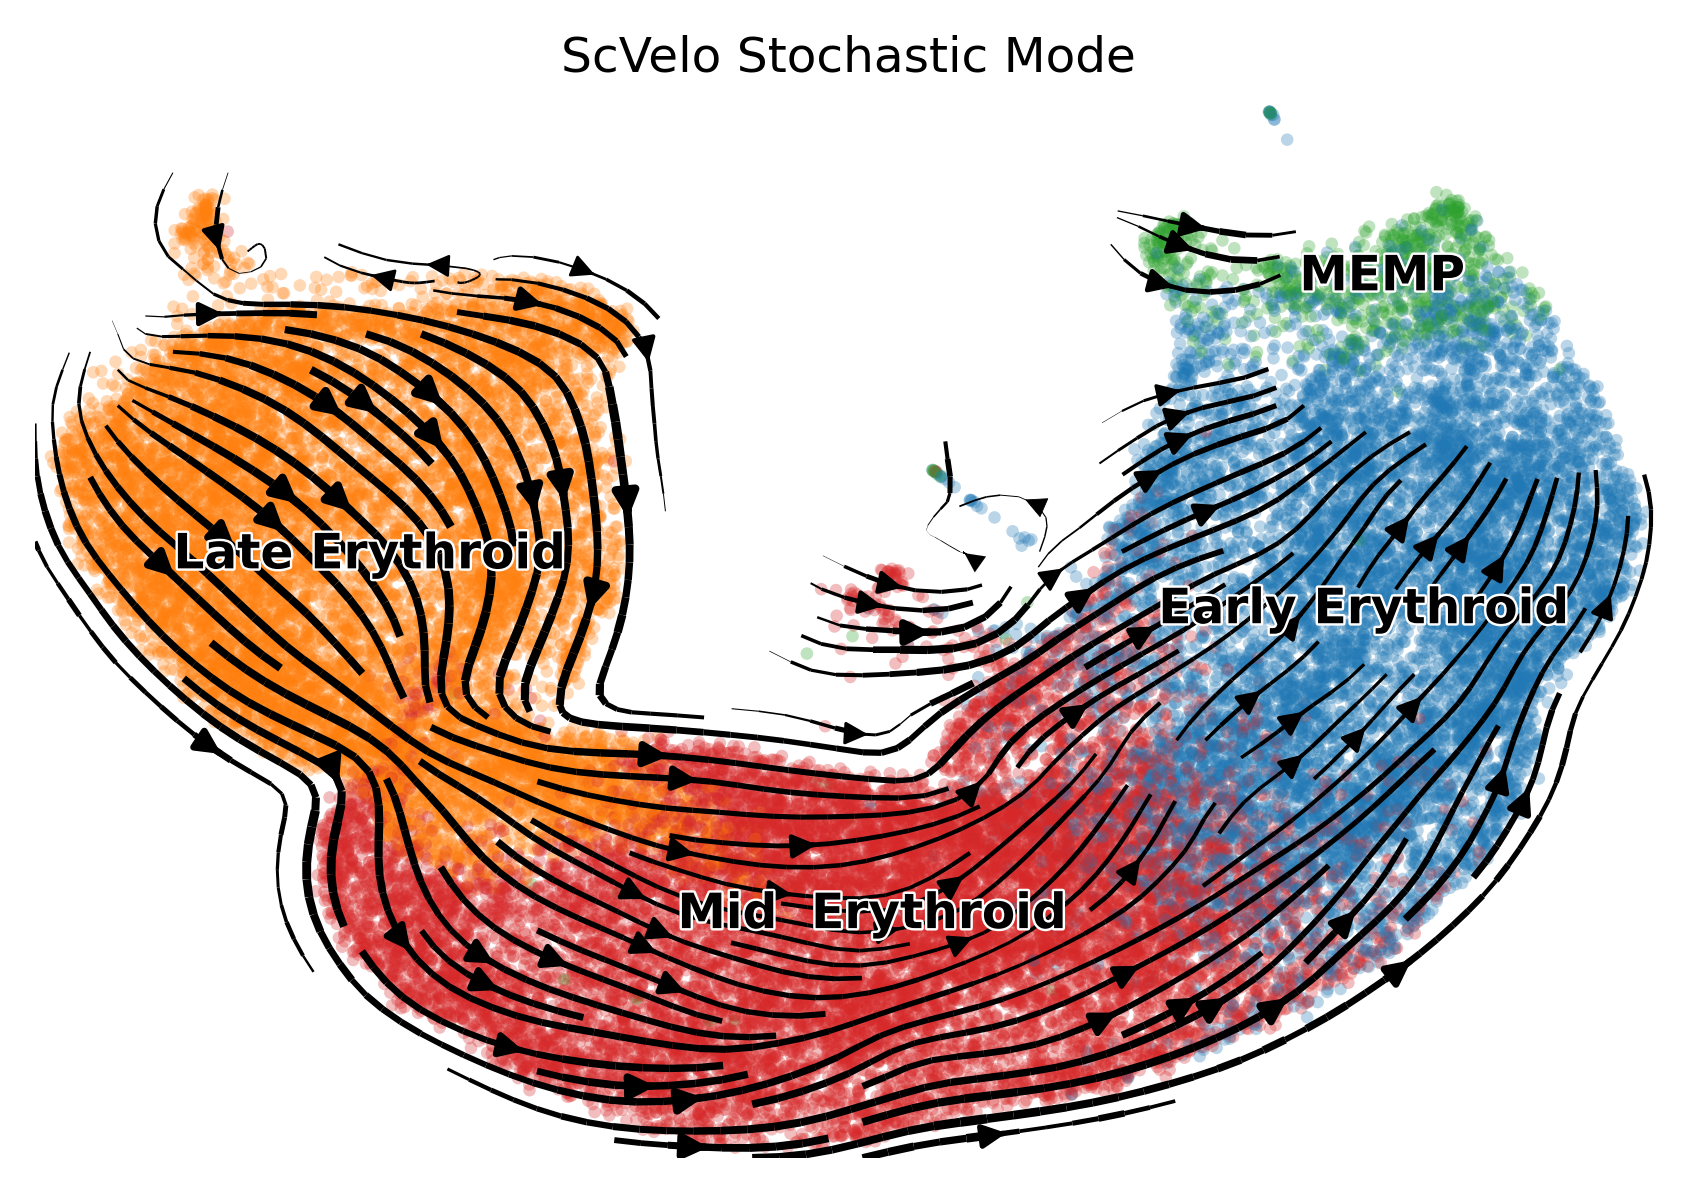

# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.081447646, ('Mid  Erythroid', 'Late Erythroid'): 0.04631139}
Total Mean: 0.06387951970100403
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.7524644, ('Mid  Erythroid', 'Late Erythroid'): 0.891103}
Total Mean: 0.821783721446991
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): -0.3915759926120027, ('Mid  Erythroid', 'Late Erythroid'): -0.6590774334932159}
Total Mean: -0.5253267130526094
# In-cluster Coherence
{'Early Erythroid': 0.84404796, 'Late Erythroid': 0.9330105, 'MEMP': 0.9422879, 'Mid  Erythroid': 0.8535601}
Total Mean: 0.8932266235351562
# In-cluster Confidence
{'Early Erythroid': 0.8211951176751143, 'Late Erythroid': 0.9371989427152257, 'MEMP': 0.9497227164934267, 'Mid  Erythroid': 0.8122398725342098}
Total Mean: 0.8800891623544941


In [7]:
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=[k_cluster],dpi=350,
                                title='ScVelo Stochastic Mode', save="Melania_Erythroid_human_stochastical.png")
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity", x_emb="X_umap")

computing neighbors
    finished (0:00:54) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:18) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 5724.089844
Train Epoch: 200/20000 	Loss: 5724.006348
Train Epoch: 300/20000 	Loss: 5723.895996
Train Epoch: 400/20000 	Loss: 5724.908691
Train Epoch: 500/20000 	Loss: 5723.859375
Train Epoch: 600/20000 	Loss: 5723.819824
Train Epoch: 700/20000 	Loss: 5664.509277
Train Epoch: 800/20000 	Loss: 5680.567383
Train Epoch: 900/20000 	Loss: 5624.047363
Train Epoch: 1000/20000 	Loss: 5574.755859
Train Epoch: 1100/20000 	Loss: 5716.375977
Train Epoch: 1200/20000 	Loss: 5531.036621
Train Epoch: 1300/20000 	Loss: 5491.680176
Train Epoch: 1400/20000 	Loss: 5688.745605
Train Epoch: 1500/20000 	Loss: 5435.228027
Train Epoch: 1600/20000 	Loss: 5410.302734
Train Epoch: 1700/20000 	Loss: 5316.215332
Tr

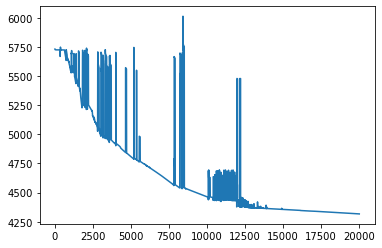

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

computing neighbors
    finished (0:00:18) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:15) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:17) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph (using 1/40 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:57) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:20) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_Melania_Erythroid_human_pojection.png


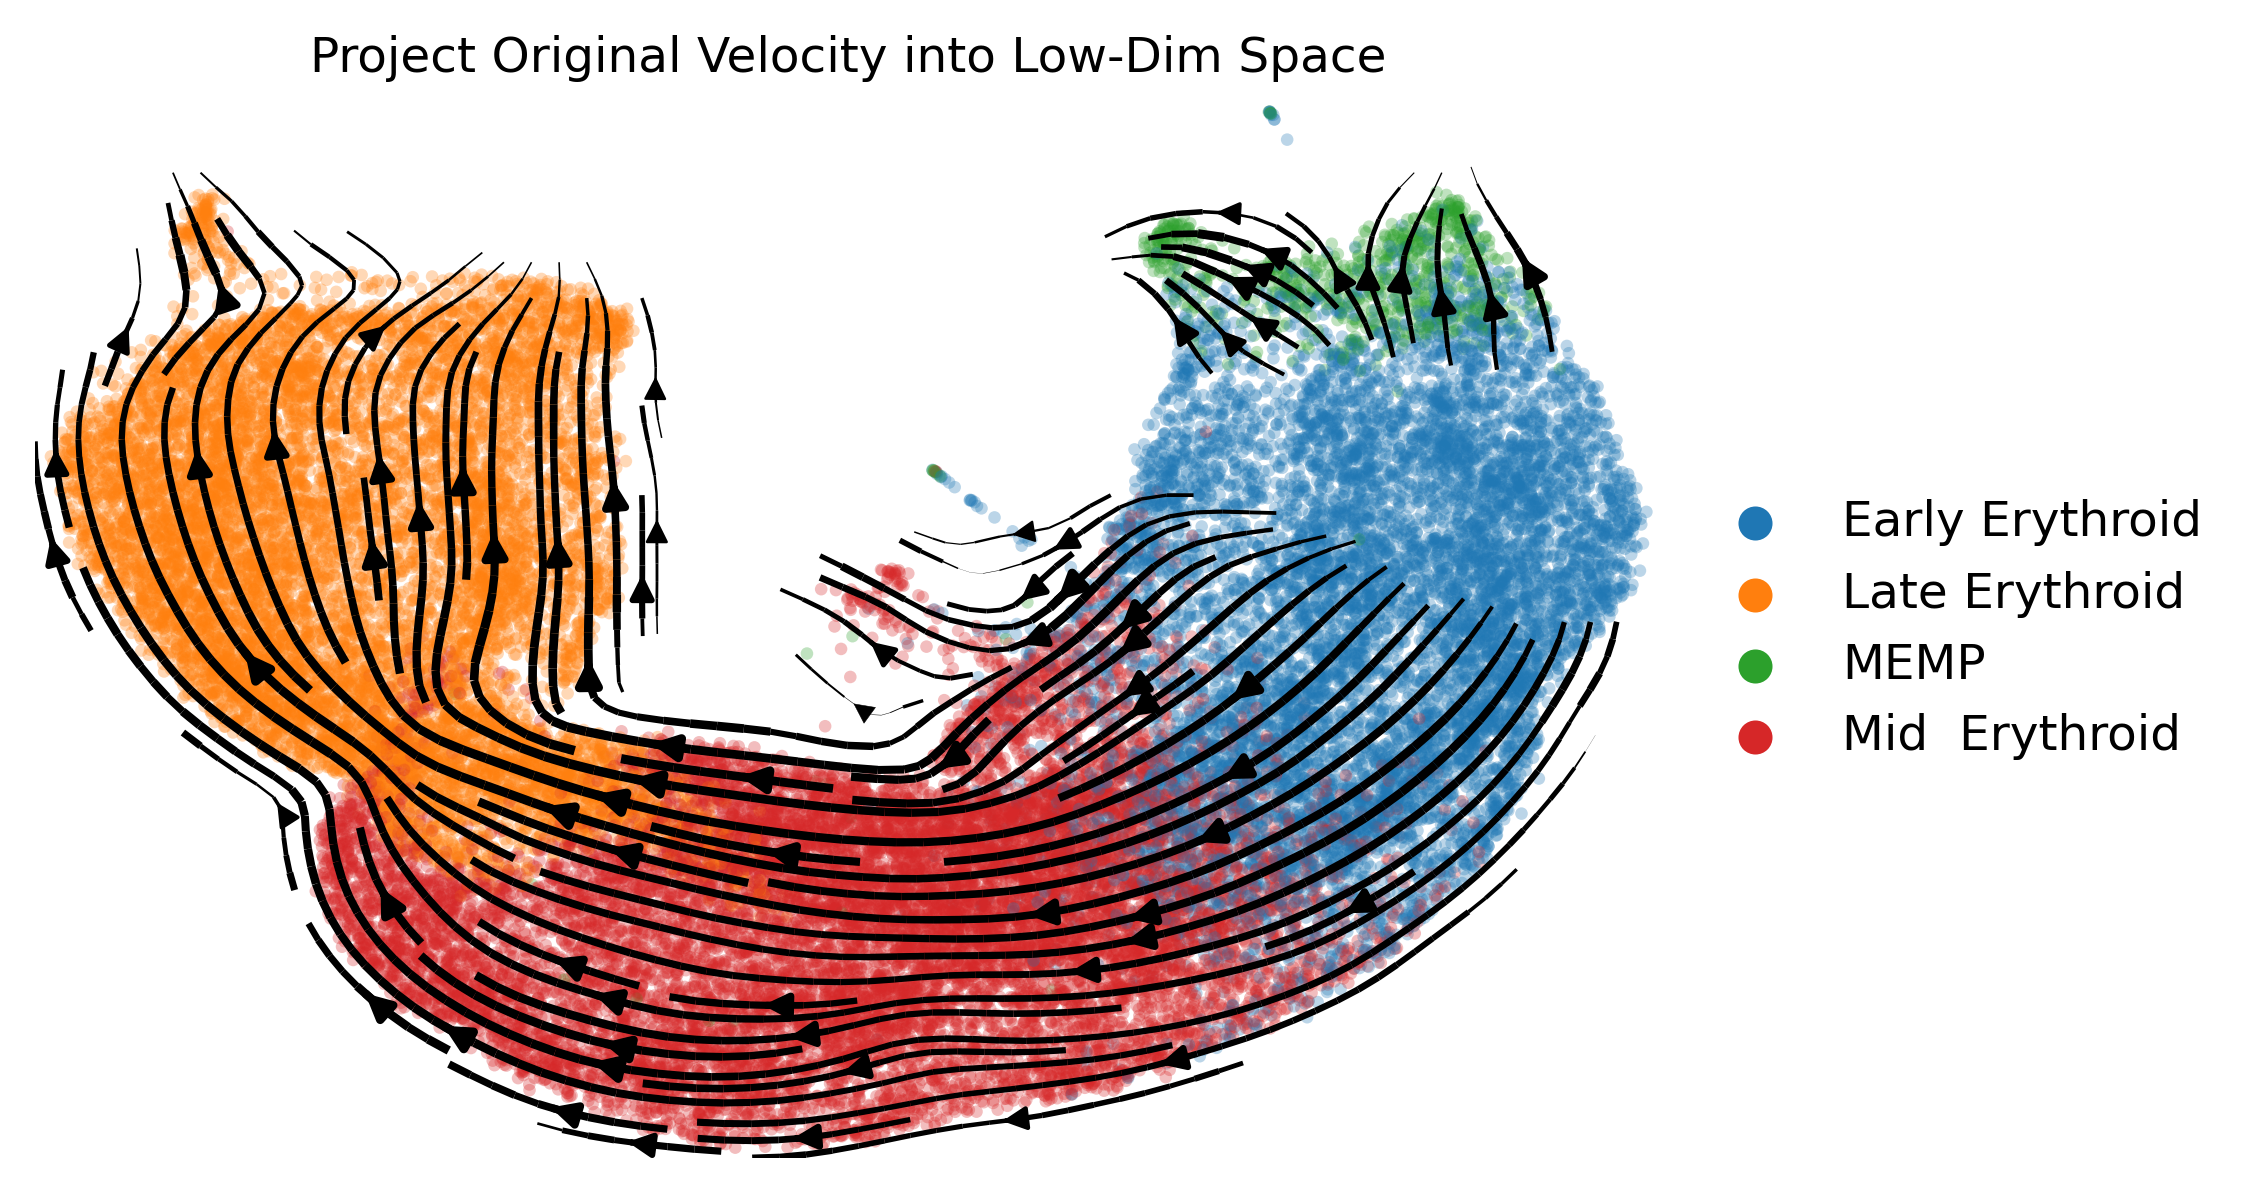

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.81448275, ('Mid  Erythroid', 'Late Erythroid'): 0.84307027}
Total Mean: 0.828776478767395
# Cross-Boundary Velocity Coherence (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.9999128, ('Mid  Erythroid', 'Late Erythroid'): 0.99988}
Total Mean: 0.9998964071273804
# Cross-Boundary Direction Correctness (A->B)
{('Early Erythroid', 'Mid  Erythroid'): 0.5946449542504035, ('Mid  Erythroid', 'Late Erythroid'): 0.7034550966965892}
Total Mean: 0.6490500254734963
# In-cluster Coherence
{'Early Erythroid': 0.9999347, 'Late Erythroid': 0.9998519, 'MEMP': 0.99994457, 'Mid  Erythroid': 0.99992007}
Total Mean: 0.9999127984046936
# In-cluster Confidence
{'Early Erythroid': 0.99992859820819, 'Late Erythroid': 0.9998399716205147, 'MEMP': 0.9999327535149436, 'Mid  Erythroid':

In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis="X")
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, legend_loc='right_margin', vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='Melania_Erythroid_human_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity", x_emb="X_umap")
    
    
exp(adata, exp_metrics)

In [10]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)